Text(0, 0.5, 'Geometry Factor')

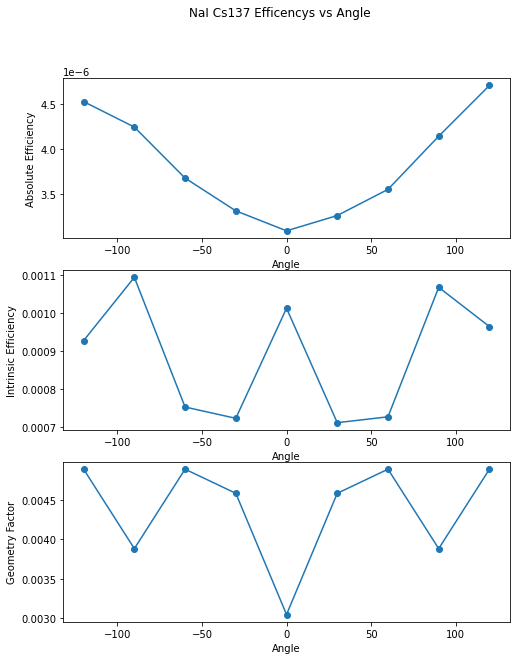

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from scipy.optimize import curve_fit
from numpy import inf as INF

# folder path
dir_path = r"C:\Users\Home\Desktop\Lab Data Master\Ni Cs137 Angles"

# to store file names
res = []

# construct path object
d = pathlib.Path(dir_path)

# iterate directory
for entry in d.iterdir():
    # check if it a file
    if entry.is_file():
        res.append(entry)
        
CHANNELS = np.array(list(range(1024)))
ANGLE = [-120,-90,-60,-30,0,30,60,90,120]
#BACKGROUND = (np.genfromtxt(res[1],skip_header=12,skip_footer=73)/600)
COUNTS_M_120 = (np.genfromtxt(res[0],skip_header=12,skip_footer=14))/300
COUNTS_M_90 = (np.genfromtxt(res[3],skip_header=12,skip_footer=14))/300
COUNTS_M_60 = (np.genfromtxt(res[2],skip_header=12,skip_footer=14))/300
COUNTS_M_30 = (np.genfromtxt(res[1],skip_header=12,skip_footer=14))/300
COUNTS_0 = (np.genfromtxt(res[4],skip_header=12,skip_footer=14))/300
COUNTS_30 = (np.genfromtxt(res[6],skip_header=12,skip_footer=14))/300
COUNTS_60 = (np.genfromtxt(res[7],skip_header=12,skip_footer=14))/300
COUNTS_90 = (np.genfromtxt(res[8],skip_header=12,skip_footer=14))/300
COUNTS_120 = (np.genfromtxt(res[5],skip_header=12,skip_footer=14))/300
Roi_Start = 370
Roi_End = 500
Top = 8

def plot_spectrum(ax, channels, counts, 
                  xlabel='Channels', ylabel='Counts/Second', 
                  **kwargs):
    """Helper function to plot spectra."""
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)

    return ax.scatter(channels, counts, **kwargs)


TWO_PI = np.pi * 2.

def gaussian(x, mu, sig, a):
    return a * np.exp(-0.5 * (x-mu)**2 / sig**2) / np.sqrt(TWO_PI * sig**2)


def in_interval(x, xmin=-INF, xmax=INF):
    """Boolean mask with value True for x in [xmin, xmax) ."""
    _x = np.asarray(x)
    return np.logical_and(xmin <= _x, _x < xmax) 

def filter_in_interval(x, y, xmin, xmax):
    """Selects only elements of x and y where xmin <= x < xmax."""
    # TODO: check x.shape == y.shape?
    _mask = in_interval(x, xmin, xmax)
    return [np.asarray(x)[_mask] for x in (x, y)]

def colourmask(x, xmin=-INF, xmax=INF, cin='red', cout='gray'):
    """Colour cin if within region of interest, cout otherwise."""
    # compute mask as integers 0 or 1
    _mask = np.array(in_interval(x, xmin, xmax), dtype=int)

    # convert to colours
    colourmap = np.array([cout, cin])
    return colourmap[_mask]

def simple_model_fit(model, channels, counts, roi, **kwargs):
    """Least squares estimate of model parameters."""
    # select relevant channels & counts
    _channels, _counts = filter_in_interval(channels, counts, *roi)
    
    # fit the model to the data
    popt, pcov = curve_fit(model, _channels, _counts, **kwargs)
    return popt, pcov

def format_result(params, popt, pcov):
    """Display parameter best estimates and uncertainties."""
    # extract the uncertainties from the covariance matrix
    perr = np.sqrt(np.diag(pcov))
    
    # format parameters with best estimates and uncertainties
    # TODO: should probably round these to a sensible precision! 
    _lines = (f"{p} = {o} ± {e}" for p, o, e in zip(params, popt, perr))
    return "\n".join(_lines)

def plot_model(ax, model, xrange, ps, npoints=1001, **kwargs):
    """Plots a 1d model on an Axes smoothly over xrange."""
    _channels = np.linspace(*xrange, npoints)
    _counts   = model(_channels, *ps)
    
    return ax.plot(_channels, _counts, **kwargs)

def first_moment(x, y):
    return np.sum(x * y) / np.sum(y)
    
def second_moment(x, y):
    x0 = first_moment(x, y)
    return np.sum((x-x0)**2 * y) / np.sum(y)

def gaussian_initial_estimates1(channels, counts):
    """Estimates of the three parameters of the gaussian distribution."""
    mu0 = first_moment(channels, counts)
    sig0 = np.sqrt(second_moment(channels, counts))
    a0 = np.sum(counts)
    
    return (mu0, sig0, a0)

a_values = []
all_counts = [COUNTS_M_120,COUNTS_M_90,COUNTS_M_60,COUNTS_M_30,COUNTS_0,COUNTS_30,COUNTS_60,COUNTS_90,COUNTS_120]

def find_a_values(x, y, z):
    
    for values in all_counts:

        GAUSSIAN_PARAMS = ('mu', 'sig', 'a')
        ROI = (x, y)

        # make initial estimates
        _channels, _counts = filter_in_interval(CHANNELS, values, *ROI)
        _p0 = gaussian_initial_estimates1(_channels, _counts)

        # do the fit
        popt, pcov = simple_model_fit(gaussian, CHANNELS, values, ROI, p0=_p0)
        a_values.append(popt[2])
    
find_a_values(Roi_Start, Roi_End, Top)

#am_t = 432.2
#cs_t = 30.09
#co_t = 5.2714
#ba_t = 10.537

half_life = 949038600
lam = 0.693/half_life
t_NaI = 1377228322  #am ba- cs co

#activity of lab 2 sources
A_cs2 = 37000*12.41*np.exp(-lam*t_NaI)*300


FEPE = []
for x in range(9):
    result = a_values[x]/A_cs2
    FEPE.append(result)
    
radius = 0.0254
length = 0.0508
distance = 0.23
geo_factor= []
radians = 0.0174533
ANGLE_RADIANS = []
for i in range(9):
    result = ANGLE[i]*radians
    ANGLE_RADIANS.append(result)

for x in ANGLE_RADIANS:
    area_of_detector = ((np.pi*radius**2)*abs(np.cos(x)) + 2*radius*length*abs(np.sin(x)))
    geo_f = area_of_detector/(4*np.pi*distance**2) 
    geo_factor.append(geo_f)
    
intrinsic_Eff = [i / j for i, j in zip(FEPE, geo_factor)]

fig, ax = plt.subplots(3, figsize=(8, 10))
ax[0].scatter(ANGLE,FEPE)
ax[0].plot(ANGLE,FEPE)
ax[0].set_xlabel('Angle')
ax[0].set_ylabel('Absolute Efficiency')
fig.suptitle('NaI Cs137 Efficencys vs Angle')

           
ax[1].scatter(ANGLE,intrinsic_Eff)
ax[1].plot(ANGLE,intrinsic_Eff)
ax[1].set_xlabel('Angle')
ax[1].set_ylabel('Intrinsic Efficiency')


ax[2].scatter(ANGLE,geo_factor)
ax[2].plot(ANGLE,geo_factor)
ax[2].set_xlabel('Angle')
ax[2].set_ylabel('Geometry Factor')

